In [1]:
import scipy as sp
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with primary porosity

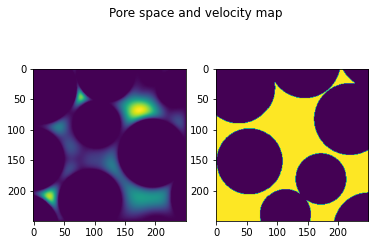

In [2]:
slice = 20

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])




In [ ]:
# testIM = primaryImage.astype(bool)
# testIM = testIM[:,:,slice]
# skelIM = ski.morphology.skeletonize(testIM)
#
# plt.imshow(skelIM)

# Extract pore network information

In [3]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)

nRegions = np.unique(snowFiltPrimary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:05<00:00, 18.18it/s]


# Plot velocity histogram for simulation

Text(0.5, 0, 'All pore velocities')

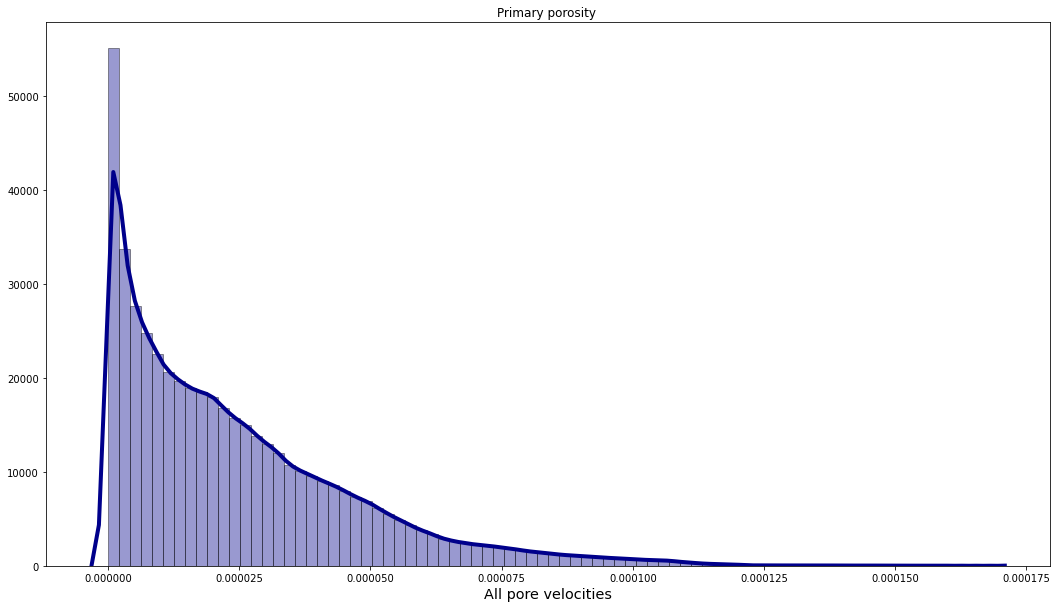

In [4]:
allPrimaryVelocities = np.ndarray.flatten(velDataNormPrimary)

filtIndex = allPrimaryVelocities > 0
trueZeroIndex = allPrimaryVelocities == 0

filtPrimaryVelocities = allPrimaryVelocities[filtIndex]
filtZeroPrimaryVelocities = allPrimaryVelocities[trueZeroIndex]

fig, axes = plt.subplots(1, 1, figsize=(18, 10))
sns.distplot(filtPrimaryVelocities, ax=axes, hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes.set_title('Primary porosity ')
axes.set_xlabel('All pore velocities',fontsize='x-large')


# Skeleton implementation


In [5]:
primaryRegionData = ps.metrics.regionprops_3D(snowFiltPrimary.regions) #Gives properties for each region
primaryRegionData.append([])

primaryRegions = snowFiltPrimary.regions

100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


------------------------------------------------------------
Calculating regionprops


Find skeleton for primary image and collect info

In [21]:
cubeSize = len(primaryImage)
primarySkelImage = np.zeros(primaryImage.shape)
edgeImage = np.zeros(primaryImage.shape)
visit = np.zeros(len(primaryRegionData))
primaryRegionImage = np.zeros(primaryImage.shape)
primaryPoreDiamImage = np.zeros(primaryImage.shape)

for a in range(0,cubeSize):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            regionLabel = snowFiltPrimary.regions[a,b,c]
            if regionLabel != 0: # Don't want grains to be counted
                regionLabel = regionLabel - 1 # Adjusting index to work with region props command
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    #index = snowFiltPrimary.regions[a,b,c]
                    regionInd = snowFiltPrimary.regions == regionLabel
                    regionBorder = primaryRegionData[regionLabel].slice
                    primarySkelImage[regionBorder[0],regionBorder[1],regionBorder[2]] = primaryRegionData[regionLabel].skeleton
                    #edgeImage[snowFiltPrimary.regions[a,b,c] == regionLabel] = regionData[regionLabel].border

                    primaryRegionImage[regionBorder[0],regionBorder[1],regionBorder[2]] =  regionLabel

                    poreDiam =  poreInfoPrimary['pore.diameter'][regionLabel]
                    primaryPoreDiamImage[regionBorder[0],regionBorder[1],regionBorder[2]] = poreDiam

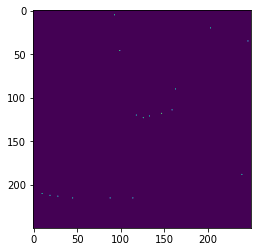

In [7]:
plt.imshow(primarySkelImage[:,:,40])

# ps.io.to_vtk(primarySkelImage,'PS_skeletonImage')
#primaryImage[primaryImage == 1] = 255 # Make red/blue distinction
#ps.io.to_vtk(primaryImage,'primaryImage')


# Now plot velocitites on skeleton and extract information

In [24]:
primaryVelocitiesSkeleton = []
primaryPoreDiamSkeleton = []
primaryPoreRegionSkeleton = []

for a in range(0,cubeSize):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if primarySkelImage[a,b,c] != 0:
                primaryVelocitiesSkeleton = np.append(primaryVelocitiesSkeleton,velDataNormPrimary[a,b,c])
                primaryPoreDiamSkeleton = np.append(primaryPoreDiamSkeleton, primaryPoreDiamImage[a,b,c])
                primaryPoreRegionSkeleton = np.append(primaryPoreRegionSkeleton, primaryRegionImage[a,b,c])

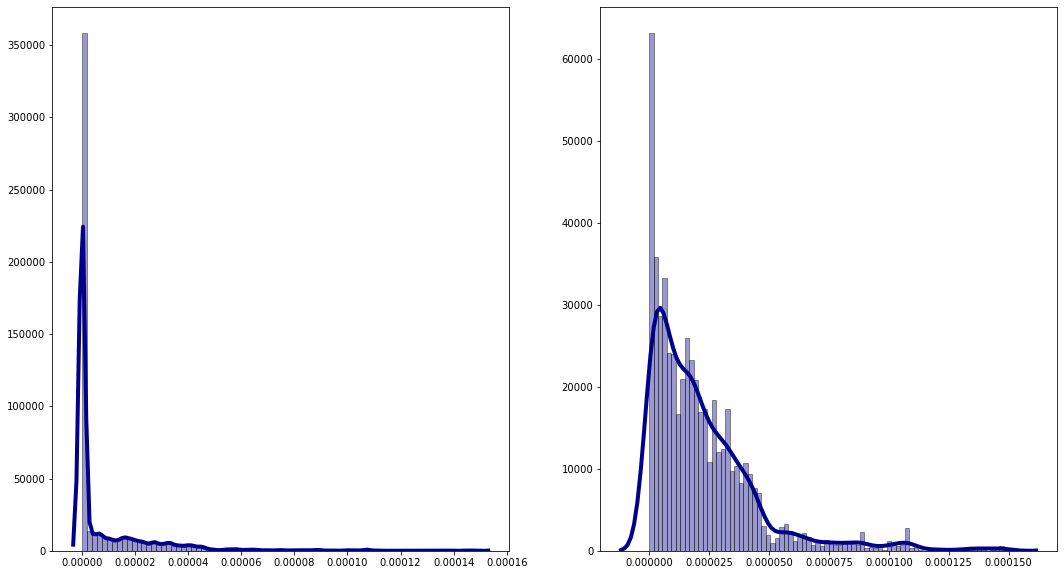

In [9]:
# The zeros seen here are truely no flow I think, they aren't pore walls and this is after the flow simulation, so
# even though the initial lattice state is v = 0, these are still zero

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.distplot(primaryVelocitiesSkeleton, ax=axes[0], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(primaryVelocitiesSkeleton[primaryVelocitiesSkeleton != 0], ax=axes[1], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


# Plot pore velocities with pore diameters



Text(0.5, 1.0, 'All pore velocities on skeleton')

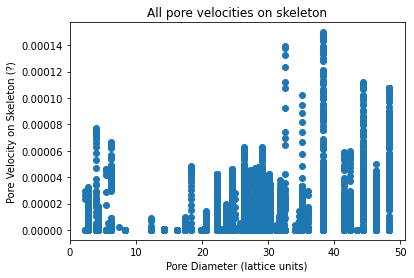

In [25]:
plt.scatter(primaryPoreDiamSkeleton, primaryVelocitiesSkeleton)
plt.xlabel('Pore Diameter (lattice units)')
plt.ylabel('Pore Velocity on Skeleton (?)')
plt.title('All pore velocities on skeleton')

Try taking median velocity

In [26]:
medianPoreVelocity =  np.zeros(nRegions,)

for a in range(0, medianPoreVelocity.size):
    skeletonPoreVel = primaryVelocitiesSkeleton[primaryPoreRegionSkeleton == a]
    medianPoreVelocity[a] = np.median(skeletonPoreVel)


E:\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
